# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `/global/u2/j/jaimerz/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, #CUDA,
    JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;

In [5]:
prob = load_cmb_lensing_problem(;storage=Array, T, Nside, masking=true, global_parameters=true);

In [6]:
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

112.09

# MCHMC

In [7]:
target = CMBLensingTarget(prob);

In [8]:
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);

In [9]:
p_precond = load("../chains/pixel_preconditioners/pp_nside_64", 
               "dist_mat_precond")
#p_precond = adapt(CuArray, p_precond)
p_precond = from_vec(p_precond);

In [10]:
precond = one(simulate(Diagonal(one(LenseBasis(diag(prob.Λmass))))));

## Sample

In [11]:
TEV = 0.0001
spl = MCHMC(500, TEV; adaptive=true, init_eps=30, init_L=10.0*sqrt(50), sigma=precond);

In [ ]:
prob.ncalls[] = 0
samples_mchmc = adapt(Array, Sample(spl, target, 10_000, dialog=false, progress=true,
                      file_name=string("../chains/MCHMC/CMBLensing_masked_Nside_", Nside, "_TEV_", TEV, "_2")));
ncalls_mchmc = prob.ncalls[]

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  17%|█████▉                             |  ETA: 0:02:09

In [16]:
samples_mchmc  = load("../chains/MCHMC/CMBLensing_masked_pp_Nnside_64_TEV_0.0001", "samples")

24583×10000 Matrix{Float64}:
    -0.302619     -0.322767     -0.318401  …      4.12253         4.10503
     0.58954       0.616688      0.617681         1.38084         1.39218
     0.25875       0.274339      0.265707         1.72509         1.73524
     1.35307       1.33907       1.32746          2.14114         2.16465
     2.00752       1.99029       1.98207          0.279882        0.293759
     1.30337       1.32365       1.28507   …     -0.00571998      0.0061193
     1.65043       1.61482       1.59419          2.84269         2.86964
     0.714233      0.756783      0.719081         1.65416         1.65281
    -0.312385     -0.262955     -0.235328        -0.108322       -0.120437
     0.384906      0.359797      0.336653        -0.0157056      -0.0178023
    -0.279247     -0.288922     -0.29779   …     -0.101955       -0.0942558
    -0.184075     -0.198328     -0.196308         0.307656        0.290664
     0.962715      0.970663      1.00115          2.0221          2.04792


In [22]:
chain_mchmc = Chains(
    permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf],
);

In [23]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 275.1066571219562
 242.3079846836864

In [24]:
ess_per_call_mchmc = ess_mchmc / 10000 #ncalls_mchmc

2-element Vector{Float64}:
 0.02751066571219562
 0.02423079846836864

In [25]:
size(samples_mchmc)

(24583, 10000)

## Plot

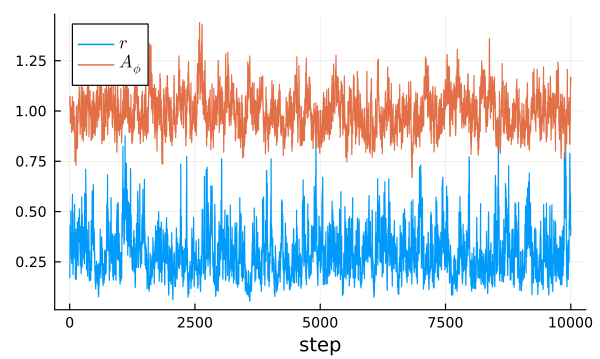

In [26]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

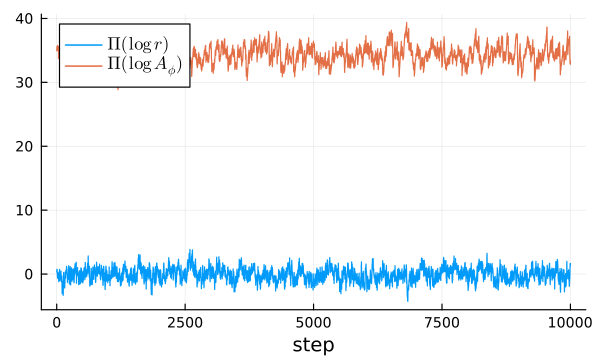

In [27]:
plot(chain_mchmc[:p_logr], label=L"\Pi(\log \, r)", xlabel="step")
plot!(chain_mchmc[:p_logAϕ], label=L"\Pi(\log \, A_\phi)")

In [44]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

LoadError: UndefVarError: `d` not defined

In [45]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d]

LoadError: UndefVarError: `d` not defined

In [46]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2)

LoadError: UndefVarError: `vars` not defined

In [47]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
plot!(vars, label=string("Parameter space --> K = ", k))

LoadError: UndefVarError: `_k` not defined

In [48]:
using CMBLensing: fit, Histogram, Weights
_vars_q = _vars[1:Int((d-2)/3)]
_vars_u = _vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

LoadError: UndefVarError: `_vars` not defined

In [49]:
_edges = range(0,13,length=20)
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_vars_q), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_vars_u), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
plot(_edges, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field", alpha=0.7)
plot!(_edges, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field", alpha=0.7)

LoadError: UndefVarError: `dist_mat` not defined

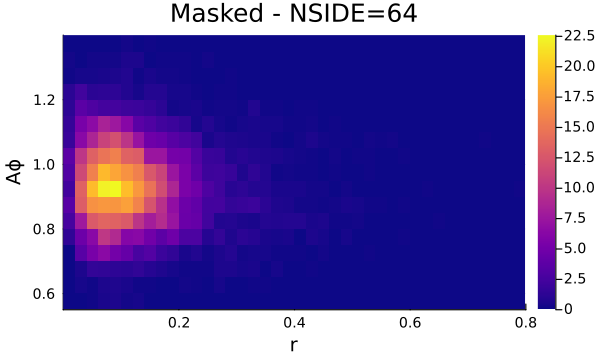

In [50]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

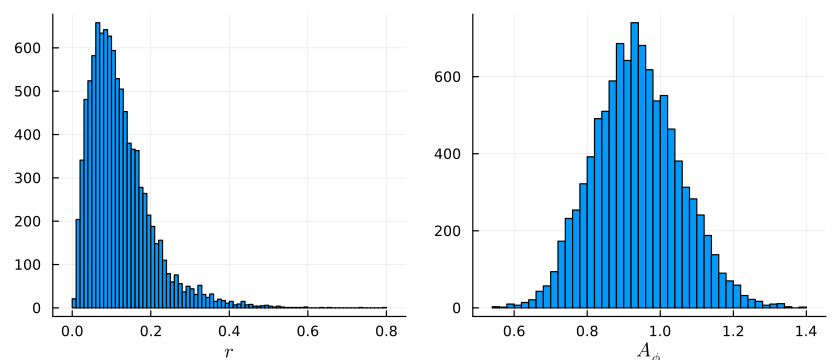

In [51]:
plot(
    histogram(chain_mchmc[:r], xlabel=L"r", label=nothing, lw=1),
    histogram(chain_mchmc[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
    size = (700,300)
)

In [52]:
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_vars_q), range(0,13,length=20)).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), range(0,13,length=20)).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_vars_u), range(0,13,length=20)).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), range(0,13,length=20)).weights
plot(0.0:0.6842105263157895:13.0, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field")
plot!(0.0:0.6842105263157895:13.0, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field")

LoadError: UndefVarError: `dist_mat` not defined

### Animation

In [40]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples_mchmc[end][1:end-2]);

LoadError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Union{Real, Field, FieldOp}, [91m::typeof(!)[39m, [91m::Any[39m)
[0m[90m   @[39m [35mCMBLensing[39m [90m~/.julia/packages/CMBLensing/aN0Zc/src/[39m[90m[4mgeneric.jl:362[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:853[24m[39m
[0m  ...


In [41]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

LoadError: UndefVarError: `last_sample` not defined

In [42]:
ϕs = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples_mchmc[end-500:end]]
anim = @animate for i in 1:length(ϕs)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(ϕs, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

LoadError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Union{Real, Field, FieldOp}, [91m::typeof(!)[39m, [91m::Any[39m)
[0m[90m   @[39m [35mCMBLensing[39m [90m~/.julia/packages/CMBLensing/aN0Zc/src/[39m[90m[4mgeneric.jl:362[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:853[24m[39m
[0m  ...


In [43]:
mp4(anim, "kappa_samples.mp4", fps = 25)

LoadError: UndefVarError: `anim` not defined

# HMC

In [7]:
Ω = prob.Ωstart
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
@showprogress for i=1:500
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=0.05)], progress=false, always_accept=(i<10))
    push!(samples_hmc, state)
end
ncalls_hmc = prob.ncalls[]

Progress: 100%|█████████████████████████████████████████| Time: 0:28:57


28000

In [8]:
_samples_hmc = zeros(500, 3*64^2+2)
for i in 1:500
    _samples_hmc[i, :]  = samples_hmc[i][1][:]
end
_samples_hmc

500×12290 Matrix{Float64}:
 2.27542  5.71753  7.28278  5.60732  …  5.97051e-7  -1.37939   -0.0770131
 3.25294  6.04961  6.51444  5.47272     6.29465e-7  -1.61399   -0.116023
 2.73661  6.01705  7.57956  5.39212     7.06497e-7  -1.7794    -0.066549
 3.00653  6.16643  6.40452  3.74017     6.41242e-7  -1.05232   -0.129383
 3.0092   5.66843  5.52009  5.58824     6.07146e-7  -0.774186  -0.0340154
 2.70521  5.5883   6.80001  5.35584  …  2.55639e-7  -0.874313  -0.0666041
 2.83386  5.32116  6.38704  5.16631     9.23891e-7  -1.13797   -0.0659231
 2.83399  6.26893  6.2002   4.76452     5.21226e-7  -0.758308   0.0713522
 3.04744  4.79529  8.12032  4.76532     4.79377e-7  -1.52232    0.0163708
 4.33578  4.63462  6.95469  4.97461     3.36738e-7  -1.44113    0.0341904
 3.39243  4.89625  6.79576  3.89426  …  7.93352e-7  -1.20324    0.0124915
 3.39243  4.89625  6.79576  3.89426     7.93352e-7  -1.20324    0.0124915
 3.39243  4.89625  6.79576  3.89426     7.93352e-7  -1.20324    0.0124915
 ⋮            

In [9]:
@save string("../chains/HMC/CMBLensing_unmasked_Nnside_", Nside, "_ϵ_", 0.25) _samples_hmc

In [10]:
#samples_hmc = load("../chains/HMC/CMBLensing_masked_Nnside_64_ϵ_0.25", "_samples_hmc")

In [11]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

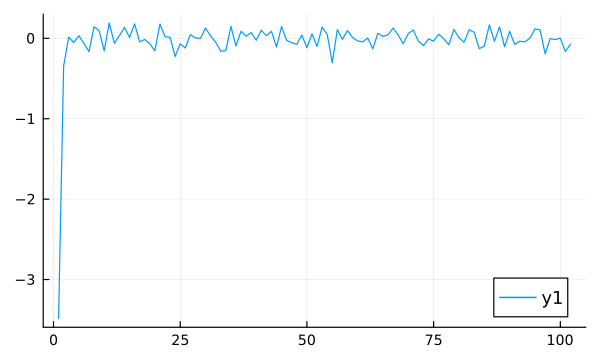

In [12]:
plot(getindex.(samples_hmc, 2))

## Plot

In [13]:
plot(exp.(samples_hmc[:, end-1]), label=L"r", xlabel="step")
plot!(exp.(samples_hmc[:, end], label=L"A_\phi")

LoadError: BoundsError: attempt to access 102-element Vector{Any} at index [1:102, 0]

In [ ]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

In [ ]:
ess_per_call_hmc = ess_hmc ./ ncalls_hmc

# MUSE

In [52]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [53]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [54]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseInferenceExt.CMBLensingMuseProblem, θ) = exp.(θ)

In [55]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [56]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

MUSE: 100%|█████████████████████████████████████████████| Time: 0:22:40
get_H: 100%|████████████████████████████████████████████| Time: 0:01:28


In [57]:
chain_muse = Chains(permutedims(rand(result.dist,1000000)), [:logr, :logAϕ]);

In [58]:
@save string("../chains/MUSE/CMBLensing_masked_Nnside_", Nside) chain_muse

In [17]:
chain_muse = load("../chains/MUSE/CMBLensing_masked_Nnside_64", "chain_muse")

Chains MCMC chain (1000000×2×1 Array{Float64, 3}):

Iterations        = 1:1:1000000
Number of chains  = 1
Samples per chain = 1000000
parameters        = logr, logAϕ

Summary Statistics
  parameters      mean       std      mcse       ess_bulk      ess_tail      r ⋯
      Symbol   Float64   Float64   Float64        Float64       Float64   Floa ⋯

        logr   -1.3451    1.7614    0.0018    997214.2752   996435.2696    1.0 ⋯
       logAϕ    0.1091    0.1855    0.0002   1000789.7430   999013.3333    1.0 ⋯
                                                               2 columns omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        logr   -4.7920   -2.5344   -1.3456   -0.1562    2.1045
       logAϕ   -0.2540   -0.0160    0.1091    0.2342    0.4731


In [60]:
ess_per_call_muse = nsims / ncalls_muse

LoadError: UndefVarError: `nsims` not defined

## Plot

In [61]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(first.(x), yscale=:log10)
        end
        plot!(first.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    # ylim = (1e-7, 1e-3)
)

LoadError: UndefVarError: `result` not defined

In [62]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(last.(x), yscale=:log10)
        end
        plot!(last.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    ylim = (1e-7, 1e-3)
)

LoadError: UndefVarError: `result` not defined

In [63]:
plot(
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :r), m="."),
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :Aϕ), m=".")
)

LoadError: UndefVarError: `result` not defined

# Compare

In [18]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

LoadError: UndefVarError: `ess_per_call_muse` not defined

In [19]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

LoadError: UndefVarError: `ess_per_call_muse` not defined

In [20]:
ess_per_call_mchmc

LoadError: UndefVarError: `ess_per_call_mchmc` not defined

In [21]:
ess_per_call_hmc

LoadError: UndefVarError: `ess_per_call_hmc` not defined

In [22]:
ess_per_call_muse

LoadError: UndefVarError: `ess_per_call_muse` not defined

In [23]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

LoadError: UndefVarError: `ess_per_call_hmc` not defined

In [24]:
p = plot(label=L"r", xlabel="step (scaled consistently for both)")
for k in [:r, :Aϕ]
    plot!(log.(chain_hmc[k][1:length(chain_mchmc)÷25]), c=1, label=(k==:r ? "HMC" : nothing))
    plot!(log.(chain_mchmc[k][1:25:end]), c=2, label=(k==:r ? "MCHMC" : nothing))
end
p

LoadError: UndefVarError: `chain_hmc` not defined

In [25]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)

LoadError: UndefVarError: `chain_hmc` not defined